# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.

Jonathan Jalbert<br/>
Professeur agrégé au Département de mathématiques et de génie industriel<br/>
Polytechnique Montréal<br/>


# Chapitre 7 - Régression linéaire bayésienne




## Contexte : Poids des perches du lac Laengelmavesi

Le fichier *fishweights.csv* contient les caractéristiques de 158 poissons péchés dans le lac Laengelmavesi en Finlande. Nous étudierons le poids (Weight en grammes) des poissons en fonction de variables explicatives suivantes :
- l'espèce de poisson (species) ;
- la longueur standard (StandardLength) ;
- la longeur non standard  (NonStandardLength) ;
- la longueur totale (TotalLength) ;
- la hauteur (Height) ;
- la largeur (Width).


          ___/////___                  _
         /           \    ___          |
       /\             \_ /  /          H
     <   )            __)  \           |
       \/_\\_________/   \__\          _

     |------- SL -------|
     |------- NSL ---------|
     |------- TL ------------|

In [1]:
using CSV 
using DataFrames
using Distributions
using Gadfly
using LinearAlgebra
import Random
using Statistics
import StatsBase

In [2]:
# using Cairo, Fontconfig

# Chargement des données

- Chargement du jeux de données
- Transformation du poids par la racine cubique pour linéariser la relation (voir le TD4)

In [3]:
data = CSV.read("fishweights.csv", DataFrame)
data[!,:Weight] = data[:,:Weight] .^(1/3)
first(data,10)

10×7 DataFrame
 Row │ Species   Weight   StandardLength  NonStandardLength  TotalLength  Heig ⋯
     │ String15  Float64  Float64         Float64            Float64      Floa ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Brème     6.23168            23.2               25.4         30.0     1 ⋯
   2 │ Brème     6.61911            24.0               26.3         31.2     1
   3 │ Brème     6.97953            23.9               26.5         31.1     1
   4 │ Brème     7.13349            26.3               29.0         33.5     1
   5 │ Brème     7.54784            26.5               29.0         34.0     1 ⋯
   6 │ Brème     7.66309            26.8               29.7         34.7     1
   7 │ Brème     7.93701            26.8               29.7         34.5     1
   8 │ Brème     7.30614            27.6               30.0         35.0     1
   9 │ Brème     7.66309            27.6               30.0         35.1     1 ⋯
  10 │ Brème     7.93701            28.5               30.7         36.2     1
                                                               2 columns omitted

## Sélection des perches

In [4]:
filter!(row -> row.Species=="Perche", data)
first(data,10)

10×7 DataFrame
 Row │ Species   Weight   StandardLength  NonStandardLength  TotalLength  Heig ⋯
     │ String15  Float64  Float64         Float64            Float64      Floa ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Perche    1.80697             7.5                8.4          8.8       ⋯
   2 │ Perche    3.1748             12.5               13.7         14.7
   3 │ Perche    3.41995            13.8               15.0         16.0
   4 │ Perche    3.72051            15.0               16.2         17.2
   5 │ Perche    4.12129            15.7               17.4         18.5       ⋯
   6 │ Perche    4.64159            16.2               18.0         19.2
   7 │ Perche    4.27266            16.8               18.7         19.4
   8 │ Perche    4.30887            17.2               19.0         20.2
   9 │ Perche    4.39683            17.8               19.6         20.8       ⋯
  10 │ Perche    4.39683            18.2               20.0         21.0
                                                               2 columns omitted

## Création du jeux de données d'entraînement et de validation

In [5]:
Random.seed!(3302)
train_id = sample(1:nrow(data), 44, replace=false, ordered=true)
valid_id = setdiff(1:nrow(data), train_id)

train = data[train_id, :]
valid = data[valid_id, :]

12×7 DataFrame
 Row │ Species   Weight    StandardLength  NonStandardLength  TotalLength  Hei ⋯
     │ String15  Float64   Float64         Float64            Float64      Flo ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Perche     4.64159            16.2               18.0         19.2      ⋯
   2 │ Perche     4.27266            16.8               18.7         19.4
   3 │ Perche     4.39683            18.2               20.0         21.0
   4 │ Perche     5.0658             19.3               21.3         22.8
   5 │ Perche     5.25359            20.7               22.7         24.2      ⋯
   6 │ Perche     6.3825             25.4               27.5         28.9
   7 │ Perche     6.42316            25.4               27.5         28.9
   8 │ Perche     9.65489            36.5               39.0         41.4
   9 │ Perche     9.3599             36.6               39.0         41.3      ⋯
  10 │ Perche     9.65489            37.0               40.0         42.5
  11 │ Perche     9.3599             37.1               40.0         42.5
  12 │ Perche    10.0                39.8               43.0         45.2
                                                               2 columns omitted

# 7.2 Régression bayésienne avec une loi *a priori* non informative

In [6]:
y = train.Weight

n = length(y)

X = hcat(ones(n), train.StandardLength)

m = size(X,2)

β̂ = X\y
println("β̂ = ", β̂)

s² = 1/(n-m) * (y-X*β̂)'*(y-X*β̂)
println("s² = ", s²)

Σ = Symmetric(inv(X'X))

β̂ = [-0.15728669540275764, 0.2606479819895741]
s² = 0.08854181925706683


2×2 Symmetric{Float64, Matrix{Float64}}:
  0.232907    -0.00831495
 -0.00831495   0.00032895

## 7.2.1 Lois conditionnelles complètes

In [7]:
f₁(σ²::Real) = MvNormal(β̂,σ²*Σ)
f₂(β::Vector{<:Real}) = InverseGamma(n/2, .5(y-X*β)'*(y-X*β)) 

f₂ (generic function with 1 method)

In [8]:
niter = 1000

β = Array{Float64}(undef, 2, niter)
σ² = Array{Float64}(undef, niter)

β[:,1] = [0, .2]
σ²[1] = .25

for j in 2:niter
    β[:,j] = rand(f₁(σ²[j-1]))
    σ²[j] = rand(f₂(β[:,j]))
end

In [9]:
fig = plot(y=β[1,:], Geom.line, Guide.xlabel("Itération"), Guide.ylabel("β₀"))
# draw(PDF("trace_beta0.pdf"), fig)

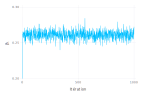

In [10]:
fig = plot(y=β[2,:], Geom.line, Guide.xlabel("Itération"), Guide.ylabel("β₁"))
# draw(PDF("trace_beta1.pdf"), fig)

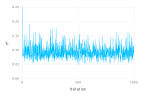

In [11]:
fig = plot(y=σ², Geom.line, Guide.xlabel("Itération"), Guide.ylabel("σ²"))
# draw(PDF("trace_sigma2.pdf"), fig)

In [12]:
# Retrait des itérations de chauffe
β = β[:, 101:end]
σ² = σ²[101:end];

## 7.2.2 Lois marginales

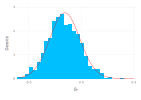

In [13]:
f = LocationScale(β̂[1], sqrt(s²*Σ[1,1]), TDist(n-m))

fig = plot(Guide.xlabel("β₀"), Guide.ylabel("Densité"), Coord.cartesian(xmin=-.6, xmax=.5),
    layer(x->pdf(f, x), -.6, .5, Theme(default_color=colorant"red")),
    layer(x=β[1,:], Geom.histogram(density=true, bincount=30))
)
# draw(PDF("marg_beta0.pdf"), fig)

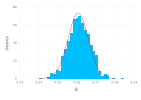

In [14]:
f = LocationScale(β̂[2], sqrt(s²*Σ[2,2]), TDist(n-m))

fig = plot(Guide.xlabel("β₁"), Guide.ylabel("Densité"),
    layer(x->pdf(f, x), .24, .28, Theme(default_color=colorant"red")),
    layer(x=β[2,:], Geom.histogram(density=true, bincount=30))
)
# draw(PDF("marg_beta1.pdf"), fig)

In [15]:
f = InverseGamma((n-m)/2,(n-m)/2*s²)

fig = plot(Guide.xlabel("σ²"), Guide.ylabel("Densité"),
    layer(x->pdf(f, x), 0, .2, Theme(default_color=colorant"red")),
    layer(x=σ², Geom.histogram(density=true, bincount=30))
)
# draw(PDF("marg_sigma2.pdf"), fig)

In [16]:
fm = InverseGamma((n-m)/2,(n-m)/2*s²)
σ̂² = mode(fm)

fd = Normal.(X*β̂, sqrt(σ̂²))

ll = sum(logpdf.(fd,y))
bic = ll - (m+1)/2*log(n)

-13.751972866734734

## Exemple 6 : Recherche du meilleur modèle unidimensionnel 

In [17]:
df = DataFrame(Variable = Symbol[], R² = Float64[], BIC = Float64[], RMSE = Float64[], )

SST = y'y 

for v in Symbol.(names(train)[3:7])
    
    X = hcat(ones(n), train[:,v])
    
    m = size(X,2)
    β̂ = X\y
    
    e = (y-X*β̂)
    SSE = e'e
    s² = 1/(n-m-2) * SSE
    
    R² = round(1-SSE/SST, digits=4)

    fd = Normal.(X*β̂, sqrt(s²))
    bic = round(sum(logpdf.(fd,y)) - (m+1)/2*log(n), digits=2)
    
    X_valid = hcat(ones(nrow(valid)), valid[:,v])

    ŷ = X_valid * β̂

    rmse = round(StatsBase.rmsd(ŷ, valid.Weight), digits=4)
    
    push!(df, [v, R², bic, rmse])
end

sort!(df, :BIC, rev=true)

5×4 DataFrame
 Row │ Variable           R²       BIC      RMSE    
     │ Symbol             Float64  Float64  Float64 
─────┼──────────────────────────────────────────────
   1 │ Height              0.9987    -5.55   0.3727
   2 │ TotalLength         0.9982   -13.08   0.21
   3 │ NonStandardLength   0.9982   -13.37   0.2259
   4 │ StandardLength      0.9982   -13.85   0.2244
   5 │ Width               0.9968   -26.36   0.3107

# 7.3 Regression Ridge

## Standardisation des variables

La standardisation s'effectue avec les fonctions `fit()` et `transform()` de la librairie *StatsBase.jl*. Les données peuvent être remises à leur échelle originale avec la fonction `reconstruct()`.

In [18]:
# Estimation des paramètres de la standardisation
ty = StatsBase.fit(StatsBase.ZScoreTransform, train.Weight)

# Standardisation des variables
y = StatsBase.transform(ty, train.Weight)

# Estimation des paramètres de la standardisation
tx = StatsBase.fit(StatsBase.ZScoreTransform, Matrix{Float64}(train[:,3:7]), dims=1)

# Standardisation des variables
X = StatsBase.transform(tx, Matrix{Float64}(train[:,3:7]));

## Estimation des paramètres 

In [19]:
n = length(y)
m = size(X,2)

λ = .2

β̂ᵣ = (X'X + λ*I)\X'y

s² = (y'y - β̂ᵣ'*(X'X + λ*I)*β̂ᵣ)/n

Σ = Symmetric(inv(X'X+λ*I))


println("β̂ᵣ = ", β̂ᵣ)
println("s² = ", s²)


β̂ᵣ = [0.15610920506391418, 0.1189102660607509, 0.13649868660268166, 0.3811022893764275, 0.20902772698077549]
s² = 0.007379113415324893


## Échantillonnage de Gibbs 

In [20]:
f₁(σ²::Real) = MvNormal(β̂ᵣ,σ²*Σ)
f₂(β::Vector{<:Real}) = InverseGamma((n+m)/2, .5(y-X*β)'*(y-X*β) + .5*λ*β'β) 

f₂ (generic function with 1 method)

In [21]:
niter = 1000

β = Array{Float64}(undef, m, niter)
σ² = Array{Float64}(undef, niter)

β[:,1] = zeros(m)
σ²[1] = .05

for j in 2:niter
    β[:,j] = rand(f₁(σ²[j-1]))
    σ²[j] = rand(f₂(β[:,j]))
end

In [22]:
fig = plot(y=β[1,:], Geom.line, Guide.xlabel("Itération"), Guide.ylabel("β₁"))

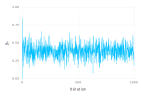

In [23]:
fig = plot(y=β[4,:], Geom.line, Guide.xlabel("Itération"), Guide.ylabel("β₄"))

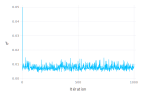

In [24]:
fig = plot(y=σ², Geom.line, Guide.xlabel("Itération"), Guide.ylabel("σ²"))

In [25]:
# Retrait des itérations de la phase de chauffe

β = β[:, 101:1000]
σ² = σ²[101:1000];

## Lois marginales

In [26]:
f = LocationScale(β̂ᵣ[1], sqrt(s²*Σ[1,1]), TDist(n))

fig = plot(Guide.xlabel("β₁"), Guide.ylabel("Densité"), Coord.cartesian(xmin=-.6, xmax=.75),
    layer(x->pdf(f, x), -.6, .75, Theme(default_color=colorant"red")),
    layer(x=β[1,:], Geom.histogram(density=true, bincount=30))
)
# draw(PDF("marg_beta0.pdf"), fig)

In [27]:
f = LocationScale(β̂ᵣ[5], sqrt(s²*Σ[5,5]), TDist(n))

fig = plot(Guide.xlabel("β₅"), Guide.ylabel("Densité"), Coord.cartesian(xmin=0, xmax=.5),
    layer(x->pdf(f, x), 0, .5, Theme(default_color=colorant"red")),
    layer(x=β[5,:], Geom.histogram(density=true, bincount=30))
)

In [28]:
f = InverseGamma(n/2,n*s²/2)

fig = plot(Guide.xlabel("σ²"), Guide.ylabel("Densité"),
    layer(x->pdf(f, x), 0, .02, Theme(default_color=colorant"red")),
    layer(x=σ², Geom.histogram(density=true, bincount=30))
)

## Trace des coefficients de régression en fonction de λ

In [29]:
df = DataFrame(λ = Float64[], β₁ = Float64[], β₂ = Float64[], β₃ = Float64[], β₄ = Float64[], β₅ = Float64[])

for λ in 0:.01:6

    β̂ = (X'X + λ*I)\X'y
    
    push!(df, [λ, β̂...])
    
end

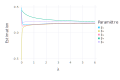

In [30]:
trace = stack(df, Not(:λ))
rename!(trace, :variable => :Paramètre, :value => :Estimation)

set_default_plot_size(12cm, 8cm)
fig = plot(trace, x=:λ, y=:Estimation, color=:Paramètre, Geom.line,
    Coord.cartesian(ymin=-.5, ymax=.5))

# draw(PDF("trace_lambda.pdf"), fig)

## Spécification de λ

La valeur de λ choisie est celle qui minimise l'erreur de prédiction (rmse) sur l'échantillon de validation.

In [31]:
# Tansformation des variables ex,plicatives de l'échantillon de validation
X_valid = StatsBase.transform(tx, Matrix{Float64}(valid[:,3:7]));

# Prédictions retransformées dans l'espaces originales
ŷ = StatsBase.reconstruct(ty, X_valid*β̂ᵣ)

12-element Vector{Float64}:
 4.364603400943222
 4.363624309590611
 4.402595906280514
 5.1116595339895134
 5.164515461137214
 6.189240113936704
 6.159819809536454
 9.381418611420077
 9.738355814787665
 9.564365425201608
 9.233504258594937
 9.940577816325362

In [32]:
StatsBase.msd(ŷ, valid.Weight)

0.037290279422069014

In [33]:
df2 = DataFrame(λ = Float64[], mse = Float64[], rmse = Float64[])

# Tansformation des variables explicatives de l'échantillon de validation
X_valid = StatsBase.transform(tx, Matrix{Float64}(valid[:,3:7]));

for λ in 0:.01:6

    # Estimation des coefficients de régression ridge
    β̂ = (X'X + λ*I)\X'y
    
    # Prédictions retransformées dans l'espaces originales
    ŷ = StatsBase.reconstruct(ty, X_valid*β̂)
    
    # Calcul du mse
    mse = StatsBase.msd(ŷ, valid.Weight)
    
    # Calcul du rmse
    rmse = StatsBase.rmsd(ŷ, valid.Weight)
    
    push!(df2, [λ, mse, rmse])
    
end

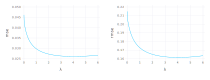

In [34]:
set_default_plot_size(21cm, 8cm)
hstack(
    plot(df2, x=:λ, y=:mse, Geom.line),
    plot(df2, x=:λ, y=:rmse, Geom.line),
    )

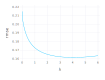

In [35]:
set_default_plot_size(10.5cm, 8cm)
fig = plot(df2, x=:λ, y=:rmse, Geom.line)
# draw(PDF("rmse_lambda.pdf"), fig)

In [36]:
sort!(df2, :rmse)
first(df2, 10)

10×3 DataFrame
 Row │ λ        mse        rmse     
     │ Float64  Float64    Float64  
─────┼──────────────────────────────
   1 │    4.04  0.0260786  0.161489
   2 │    4.03  0.0260786  0.161489
   3 │    4.05  0.0260787  0.161489
   4 │    4.02  0.0260787  0.161489
   5 │    4.06  0.0260787  0.161489
   6 │    4.01  0.0260788  0.161489
   7 │    4.07  0.0260788  0.161489
   8 │    4.0   0.0260789  0.16149
   9 │    4.08  0.026079   0.16149
  10 │    3.99  0.0260791  0.16149